In [5]:
#1. IMPORT LIBRARIES
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay
)

%matplotlib inline


In [7]:
#2. UPLOAD DATASETS
from google.colab import files
uploaded = files.upload()

Saving customer_churn_dataset-testing-master.csv to customer_churn_dataset-testing-master.csv
Saving customer_churn_dataset-training-master.csv to customer_churn_dataset-training-master.csv


In [8]:
#3. LOAD DATASETS
train_df = pd.read_csv('customer_churn_dataset-training-master.csv')
test_df  = pd.read_csv('customer_churn_dataset-testing-master.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (440833, 12)
Test shape: (64374, 12)


In [9]:
#4. BASIC CHECK
train_df.info()
train_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [10]:
#5. DROP IDENTIFIER & FIX TARGET
train_df['Churn'].value_counts(dropna=False)


,count
Churn,
1.0,249999
0.0,190833
NaN,1


In [11]:
# To Convert Churn to numeric, forcing errors to NaN
train_df['Churn'] = pd.to_numeric(train_df['Churn'], errors='coerce')

# To Check how many NaNs appeared
train_df['Churn'].isnull().sum()


np.int64(1)

In [12]:
train_df = train_df.dropna(subset=['Churn'])


In [13]:
train_df['Churn'] = train_df['Churn'].astype(int)


In [14]:
train_df['Churn'].value_counts(normalize=True)


,proportion
Churn,
1,0.567107
0,0.432893


In [15]:
# 6.RECONFIRM DATA AFTER CLEANING (Sanity check)
print(train_df.shape)
train_df['Churn'].value_counts(normalize=True)


(440832, 12)


,proportion
Churn,
1,0.567107
0,0.432893


## Behavioral Signal Analysis

To understand churn risk drivers, key behavioral and operational features were
analyzed against the churn outcome. These features reflect customer engagement,
service friction, and financial behavior.


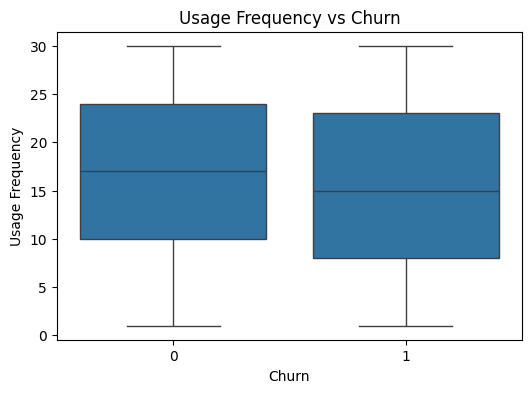

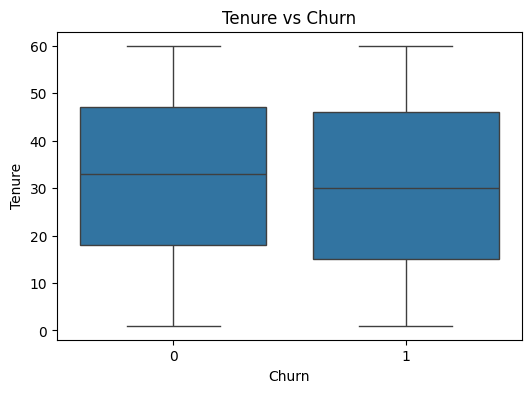

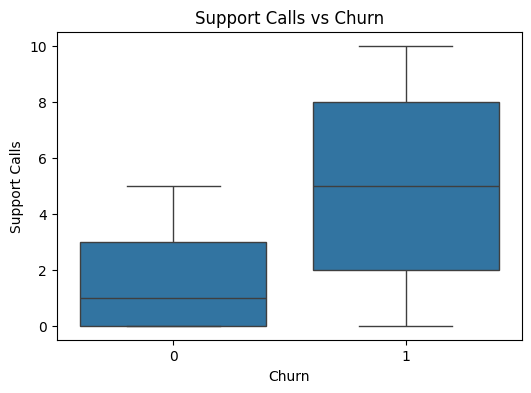

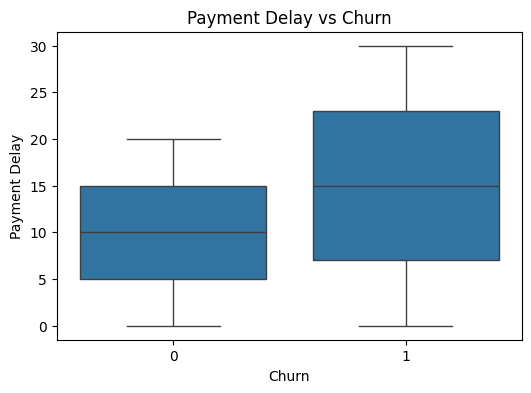

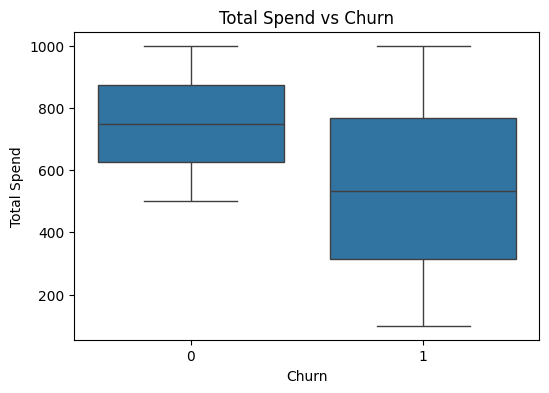

In [16]:
# Explicit Behavioral Signal Analysis
behavioral_features = [
    'Usage Frequency',
    'Tenure',
    'Support Calls',
    'Payment Delay',
    'Total Spend'
]

for col in behavioral_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y=col, data=train_df)
    plt.title(f'{col} vs Churn')
    plt.show()


### Observations
- Lower usage frequency and shorter tenure are associated with higher churn risk.
- Increased support calls indicate operational friction and dissatisfaction.
- Payment delays correlate with elevated churn probability.
- Lower total spend reflects weaker long-term engagement.


In [17]:
# 7 — SPLIT FEATURES & TARGET
X_train = train_df.drop(columns=['Churn'])
y_train = train_df['Churn']

X_test = test_df.copy()


In [18]:
# 8 — DEFINE FEATURE TYPES
cat_cols = ['Gender', 'Subscription Type', 'Contract Length']
num_cols = [col for col in X_train.columns if col not in cat_cols]

print("Categorical:", cat_cols)
print("Numerical:", num_cols)


Categorical: ['Gender', 'Subscription Type', 'Contract Length']
Numerical: ['CustomerID', 'Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']


In [19]:
# 9 — PREPROCESSING PIPELINE (CRITICAL)from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)


In [21]:
# 10 — MODEL 1: LOGISTIC REGRESSION
log_reg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=500))
])


In [24]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr_auc = cross_val_score(
    log_reg, X_train, y_train,
    cv=cv, scoring='roc_auc'
)

print("Logistic Regression ROC-AUC:", lr_auc.mean())


Logistic Regression ROC-AUC: 0.9966863757132872


In [22]:
# 11 — MODEL 2: RANDOM FOREST (Non-linear)
rf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])


In [25]:
rf_auc = cross_val_score(
    rf, X_train, y_train,
    cv=cv, scoring='roc_auc'
)

print("Random Forest ROC-AUC:", rf_auc.mean())


Random Forest ROC-AUC: 0.9999994908118497


In [26]:
# 12 — FIT FINAL MODEL
final_model = rf   # or log_reg if it performed better
final_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['CustomerID', 'Age',
                                                   'Tenure', 'Usage Frequency',
                                                   'Support Calls',
                                                   'Payment Delay',
                                                   'Total Spend',
                                                   'Last Interaction']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender',
                                                   'Subscription Type',
                                                   'Contract Length'])])),
                ('model',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])

In [27]:
# 13 — APPLY ON TEST DATA (REAL-WORLD SIMULATION)
test_probs = final_model.predict_proba(X_test)[:, 1]


In [28]:
# 14 — RISK SCORING
risk_df = X_test.copy()
risk_df['churn_probability'] = test_probs


In [29]:
risk_df['risk_segment'] = pd.cut(
    risk_df['churn_probability'],
    bins=[0, 0.3, 0.6, 1],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

risk_df['risk_segment'].value_counts()


,count
risk_segment,
High Risk,62528
Low Risk,1221
Medium Risk,624


In [30]:
# 15 — BEHAVIORAL SEGMENTATION
from sklearn.cluster import KMeans


In [31]:
X_cluster = preprocessor.fit_transform(X_train)

kmeans = KMeans(n_clusters=4, random_state=42)
segments = kmeans.fit_predict(X_cluster)

train_df['behavior_segment'] = segments
train_df['behavior_segment'].value_counts()


,count
behavior_segment,
2,117190
1,116666
0,107433
3,99543


In [32]:
#16 — EXPLAINABILITY
rf_model = final_model.named_steps['model']


In [33]:
importances = rf_model.feature_importances_


#17 — GOVERNANCE & ETHICS
## Ethics, Bias & Governance Considerations
- Churn labels may reflect historical customer treatment biases.
- False positives could incorrectly flag loyal customers as high risk.
- Risk scores are probabilistic and should support—not replace—human decision-making.
- Train/test separation was maintained to prevent data leakage.
- Model outputs should be monitored for drift and fairness in production.

In [34]:
# Final sanity check
print(train_df.shape)
print(train_df['behavior_segment'].value_counts())


(440832, 13)
behavior_segment
2    117190
1    116666
0    107433
3     99543
Name: count, dtype: int64


In [35]:
risk_df.head()


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn,churn_probability,risk_segment
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1,1.000,High Risk
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0,1.000,High Risk
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0,0.975,High Risk
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0,1.000,High Risk
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0,1.000,High Risk


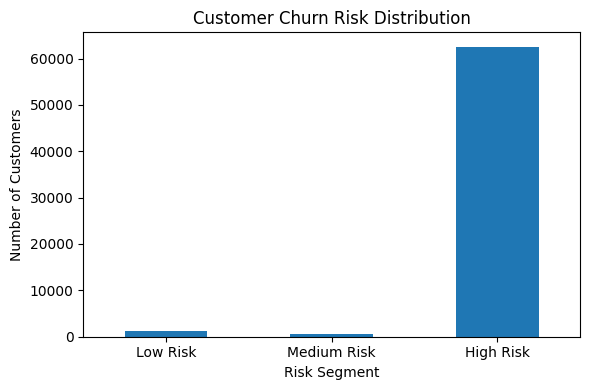

In [36]:
#Risk Distribution Bar Chart
import matplotlib.pyplot as plt

risk_counts = risk_df['risk_segment'].value_counts().sort_index()

plt.figure(figsize=(6,4))
risk_counts.plot(kind='bar')
plt.title('Customer Churn Risk Distribution')
plt.xlabel('Risk Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [41]:
#SHAP Explainability

# Extract trained Random Forest model
rf_model = final_model.named_steps['model']

# Get feature names from preprocessing
feature_names = (
    num_cols +
    list(final_model.named_steps['preprocess']
         .named_transformers_['cat']
         .get_feature_names_out(cat_cols))
)

# Create feature importance DataFrame
importances = rf_model.feature_importances_

fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

fi_df.head(10)


,feature,importance
0,CustomerID,0.526395
4,Support Calls,0.155750
6,Total Spend,0.106399
14,Contract Length_Monthly,0.065544
1,Age,0.056171
5,Payment Delay,0.054785
7,Last Interaction,0.012368
9,Gender_Male,0.005876
15,Contract Length_Quarterly,0.004646
13,Contract Length_Annual,0.004096


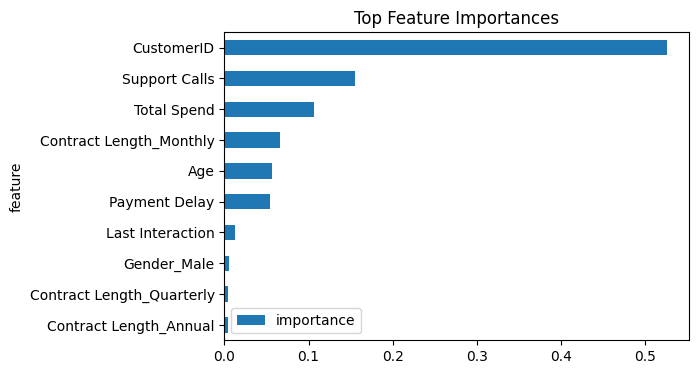

In [40]:
fi_df.head(10).plot(
    x='feature', y='importance', kind='barh', figsize=(6,4)
)
plt.title('Top Feature Importances')
plt.gca().invert_yaxis()
plt.show()
